# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt

import sys
import time

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
epochs = 50
onehot_dims = 20
maxlen = 500
num_neurons = 256
filters = 256
kernel_size = 10

count_variables = 10_000

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def positional_encoding(num_positions, num_features):
    position_enc = np.arange(num_positions)[:, np.newaxis] / np.power(10000, (
                2 * np.arange(num_features)[np.newaxis, :] // 2) / np.float32(num_features))
    position_enc[:, 0::2] = np.sin(position_enc[:, 0::2])  # Apply sine to even indices
    position_enc[:, 1::2] = np.cos(position_enc[:, 1::2])  # Apply cosine to odd indices
    return position_enc


encoded_values = positional_encoding(count_variables, onehot_dims)


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            if token_ in enc_dict:
                sample_vecs_.append(enc_dict[token_])
            else:
                sample_vecs_.append(enc_dict["UNDEF"])
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_


def make_enc_dict(x_data):
    unique_tokes = set()
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        unique_tokes = unique_tokes.union(set(tokens_))
    unique_tokes = list(unique_tokes)
    unique_tokes.sort()
    unique_tokes.append("UNDEF")

    for inx_, ut in enumerate(unique_tokes):
        enc_dict[ut] = encoded_values[inx_]


def pad_trunk(x_data):
    padded_trunked = []
    for sample_ in x_data:
        new_sample = sample_[:maxlen]
        len_diff = maxlen - len(new_sample)
        if len_diff > 0:
            for _ in range(len_diff):
                new_sample.append([0.0] * onehot_dims)
        padded_trunked.append(new_sample)
    return padded_trunked

In [4]:
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_full_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="full_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["full_terms"].tolist(), all_data["steps_num_lo"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count all terms: 4282

Count original terms: 4282

max steps count: 30
min steps count: 0
Count training samples: 2977
Count testing samples: 745


In [5]:
make_enc_dict(all_data["full_terms"])

In [6]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 31))
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

x_train = pad_trunk(x_train)
x_test = pad_trunk(x_test)

In [7]:
xy_train_data = list(zip(x_train, y_train))
xy_test_data = list(zip(x_test, y_test))

In [8]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 745
len(train_data) = 2977


In [9]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), np.array([ytd])


def val_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), np.array([ytd])

# Define the model

In [ ]:
model = Sequential()

model.add(Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(None, onehot_dims)
))

model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(units=num_neurons, activation='relu'))
model.add(Dense(units=31, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [ ]:
model_structure = model.to_json()
with open("./fine_models/v1_conv.json", 'w') as json_file:
    json_file.write(model_structure)

In [ ]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v1_conv.h5',  # Specify the path to save the best model
    monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [ ]:
history = model.fit(train_generator(), steps_per_epoch=2977, validation_data=val_generator(), validation_steps=745, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

In [ ]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

In [ ]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

In [10]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()


def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [11]:
model_name = "v1_conv"

# load the model
with open(f"./fine_models/{model_name}.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights(f"./fine_models/{model_name}.h5")

In [12]:
y_test_pred = []
for x_ in tqdm(x_test):
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])


y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

100%|██████████| 745/745 [00:53<00:00, 13.82it/s]


Test accuracy: 0.138255033557047


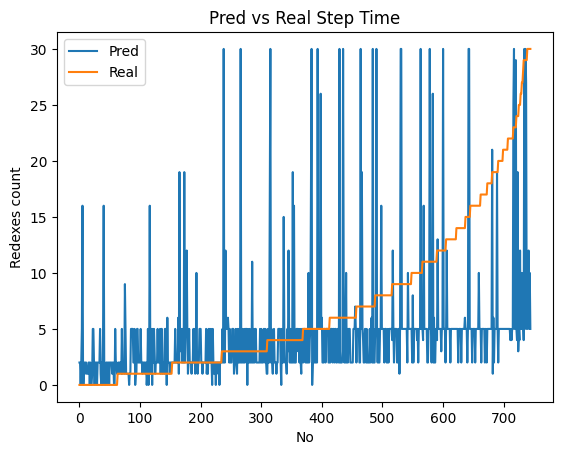

In [13]:
print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
draw_pred_lines(y_test_pred_nums, y_test_nums)

100%|██████████| 2977/2977 [02:58<00:00, 16.64it/s]


Train accuracy: 0.17265703728585824


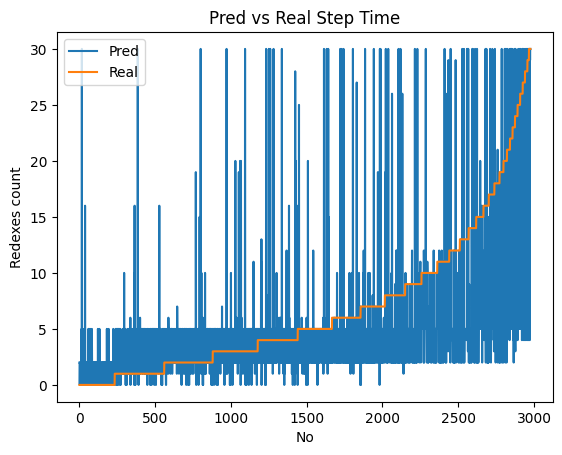

In [14]:
y_train_pred = []
for x_ in tqdm(x_train):
    y_train_pred.append(model.predict(np.array([x_]), verbose=0)[0])


y_train_pred_nums = encoder.inverse_transform(np.array(y_train_pred))
y_train_nums = encoder.inverse_transform(y_train)

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
draw_pred_lines(y_train_pred_nums, y_train_nums)

In [15]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    prediction_ = model_.predict(np.array(pad_trunk(tokenize_and_vectorize([term_.funky_v2_str()]))), verbose=0)
    print(f"{term_deskr_}\nnorm_steps={term_.normalize(LOStrategy())[1]}\tpred_steps={np.argmax(prediction_[0])}\n")


list_test_functions = (term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10, term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
norm_steps=1	pred_steps=0

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
norm_steps=5	pred_steps=2

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=5	pred_steps=2

(PRED 0) == 0 == λx. λy. y
norm_steps=4	pred_steps=2

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=15	pred_steps=5

(PLUS 0 0) == 0 == λx. λy. y
norm_steps=4	pred_steps=0

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
norm_steps=13	pred_steps=5

(SUBTRACT 3 5) == 0 == λx. λy. y
norm_steps=39	pred_steps=5

(LEQ 3 2) == FALSE == λx. λy. y
norm_steps=28	pred_steps=5

(LEQ 2 5) == TRUE == λx. λy. x
norm_steps=37	pred_steps=5

(EQ 2 2) == TRUE == λx. λy. x
norm_steps=59	pred_steps=30

(EQ 1 4) == FALSE == λx. λy. y
norm_steps=55	pred_steps=30

Omega(3, 3)  == I == λx. x
norm_steps=9	pred_steps=2

GCD_vO 5 2
norm_steps=inf	pred_steps=11

GCD_v1 5 2
norm_steps=inf	pred_steps=11

GCD_v3 5 2
norm_steps=inf	pred_steps=12

PYTHAGOREAN 5 2 2
norm_steps=inf	pred_s

In [ ]:
list_simplified_omega_terms = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        list_simplified_omega_terms.append(term_.funky_v2_str())

list_simplified_omega_terms = pad_trunk(tokenize_and_vectorize(list_simplified_omega_terms))

real_redexes_count = []

for n in tqdm(range(1, 21)):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        real_redexes_count.append(term_.normalize(LOStrategy())[1])

predictions_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    predictions_omega_terms_redexes.append(np.argmax(model.predict([rec_], verbose=0)[0]))

In [ ]:
predictions_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    predictions_omega_terms_redexes.append(np.argmax(model.predict(np.array([rec_]), verbose=0)[0]))

In [ ]:
print(predictions_omega_terms_redexes)

In [ ]:
print(real_redexes_count)

In [ ]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(real_redexes_count, predictions_omega_terms_redexes))

In [ ]:
green_dots = []
red_dots = []

for n in range(0, 20):
    for m in range(0, 20):
        val = predictions_omega_terms_redexes[n * 20 + m]
        val_real = real_redexes_count[n * 20 + m]

        if val == val_real:
            green_dots.append((n+1, m+1))
        else:
            red_dots.append((n+1, m+1))


In [ ]:
plt.figure(figsize=(12, 12))

green_dots = np.array(green_dots)
red_dots = np.array(red_dots)

plt.scatter(green_dots[:,0], green_dots[:,1], s=5, c='green',)
plt.scatter(red_dots[:,0], red_dots[:,1], s=5, c='red',)

plt.xlabel("n", fontsize=18)
plt.ylabel("m", fontsize=18)
plt.title("Omega(n, m)", fontsize=20)
plt.show()

# Do additional metrics testing

## Mean Squared Error

In [16]:
mse_train = mean_squared_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Squared Error}:", mse_test)

Train {Mean Squared Error}: 41.356399059455825
Test {Mean Squared Error}: 59.58389261744966


## Mean Absolute Error

In [17]:
mae_train = mean_absolute_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Absolute Error}:", mae_test)

Train {Mean Absolute Error}: 4.0174672489082965
Test {Mean Absolute Error}: 5.038926174496645


## Mean Absolute Percentage Error

In [18]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Absolute Percentage Error}:", mape_test)

Train {Mean Absolute Percentage Error}: 127709.25208975875
Test {Mean Absolute Percentage Error}: 175915.33464881597


## Percentage of Explained Variance (PEV)

In [19]:
# Calculate Variance of the target variable
variance_y_test = np.var(y_test_nums)
variance_y_train = np.var(y_train_nums)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Test {Percentage of Explained Variance}:", pev_test)

Train {Percentage of Explained Variance}: -1.662343131644839
Test {Percentage of Explained Variance}: -28.508301840191173


## Mean Bias Deviation

In [20]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(y_train_nums, y_train_pred_nums)
print("Train {Mean Bias Deviation}:", mbd_train)

mdb_test = mean_bias_deviation(y_test_nums, y_test_pred_nums)
print("Test {Mean Bias Deviation}:", mdb_test)

Train {Mean Bias Deviation}: 127649.88831736388
Test {Mean Bias Deviation}: 175850.70510971066


## Coefficient of Correlation (Pearson's r)

In [21]:
coc_test = np.corrcoef(y_test_pred_nums, y_test_nums)[0, 1]
coc_train = np.corrcoef(y_train_pred_nums, y_train_nums)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Test {Mean Bias Deviation}:", coc_test)

Train {Mean Bias Deviation}: 0.4744665023495244
Test {Mean Bias Deviation}: 0.2892065993014146


## Error STD

In [22]:
y_train_cl_pred_nums = np.array(y_train_pred_nums)
y_test_cl_pred_nums = np.array(y_test_pred_nums)

y_train_nums = np.array(y_train_nums)
y_test_nums = np.array(y_test_nums)
train_error = y_train_nums - y_train_cl_pred_nums
test_error = y_test_nums - y_test_cl_pred_nums
print("Train Error STD:", np.abs(train_error).std())
print("Test Error STD:", np.abs(test_error).std())

Train Error STD: 5.021588987900645
Test Error STD: 5.8474879756543565


In [23]:
def advanced_point_drawer(y_real, y_pred, title="Train dataset"):
    counter = Counter([(x_, y_) for x_, y_ in zip(y_real, y_pred)])
    coords_count = dict(counter)

    plt.figure(figsize=(12, 12))

    coords_count_rev = dict()
    for key_, val_ in coords_count.items():
        if val_ not in coords_count_rev:
            coords_count_rev[val_] = []
        coords_count_rev[val_].append(key_)

    tcoords_count_rev = dict()
    for key_ in sorted(coords_count_rev.keys()):
        tcoords_count_rev[key_] = coords_count_rev[key_]

    coords_count_rev = tcoords_count_rev

    for key_, val_ in coords_count_rev.items():
        coords_data = np.array(val_)
        plt.scatter(coords_data[:, 0], coords_data[:, 1], s=key_ ** 1 + 5, c='tab:blue', label=f"\n{key_}\n")

    plt.plot([0, 31], [0, 31], c="gray", linestyle="--")
    plt.axis("equal")
    plt.xlabel("Real", fontsize=18)
    plt.ylabel("Predict", fontsize=18)
    plt.title(title, fontsize=20)
    plt.legend(prop={'size': 10})
    plt.show()

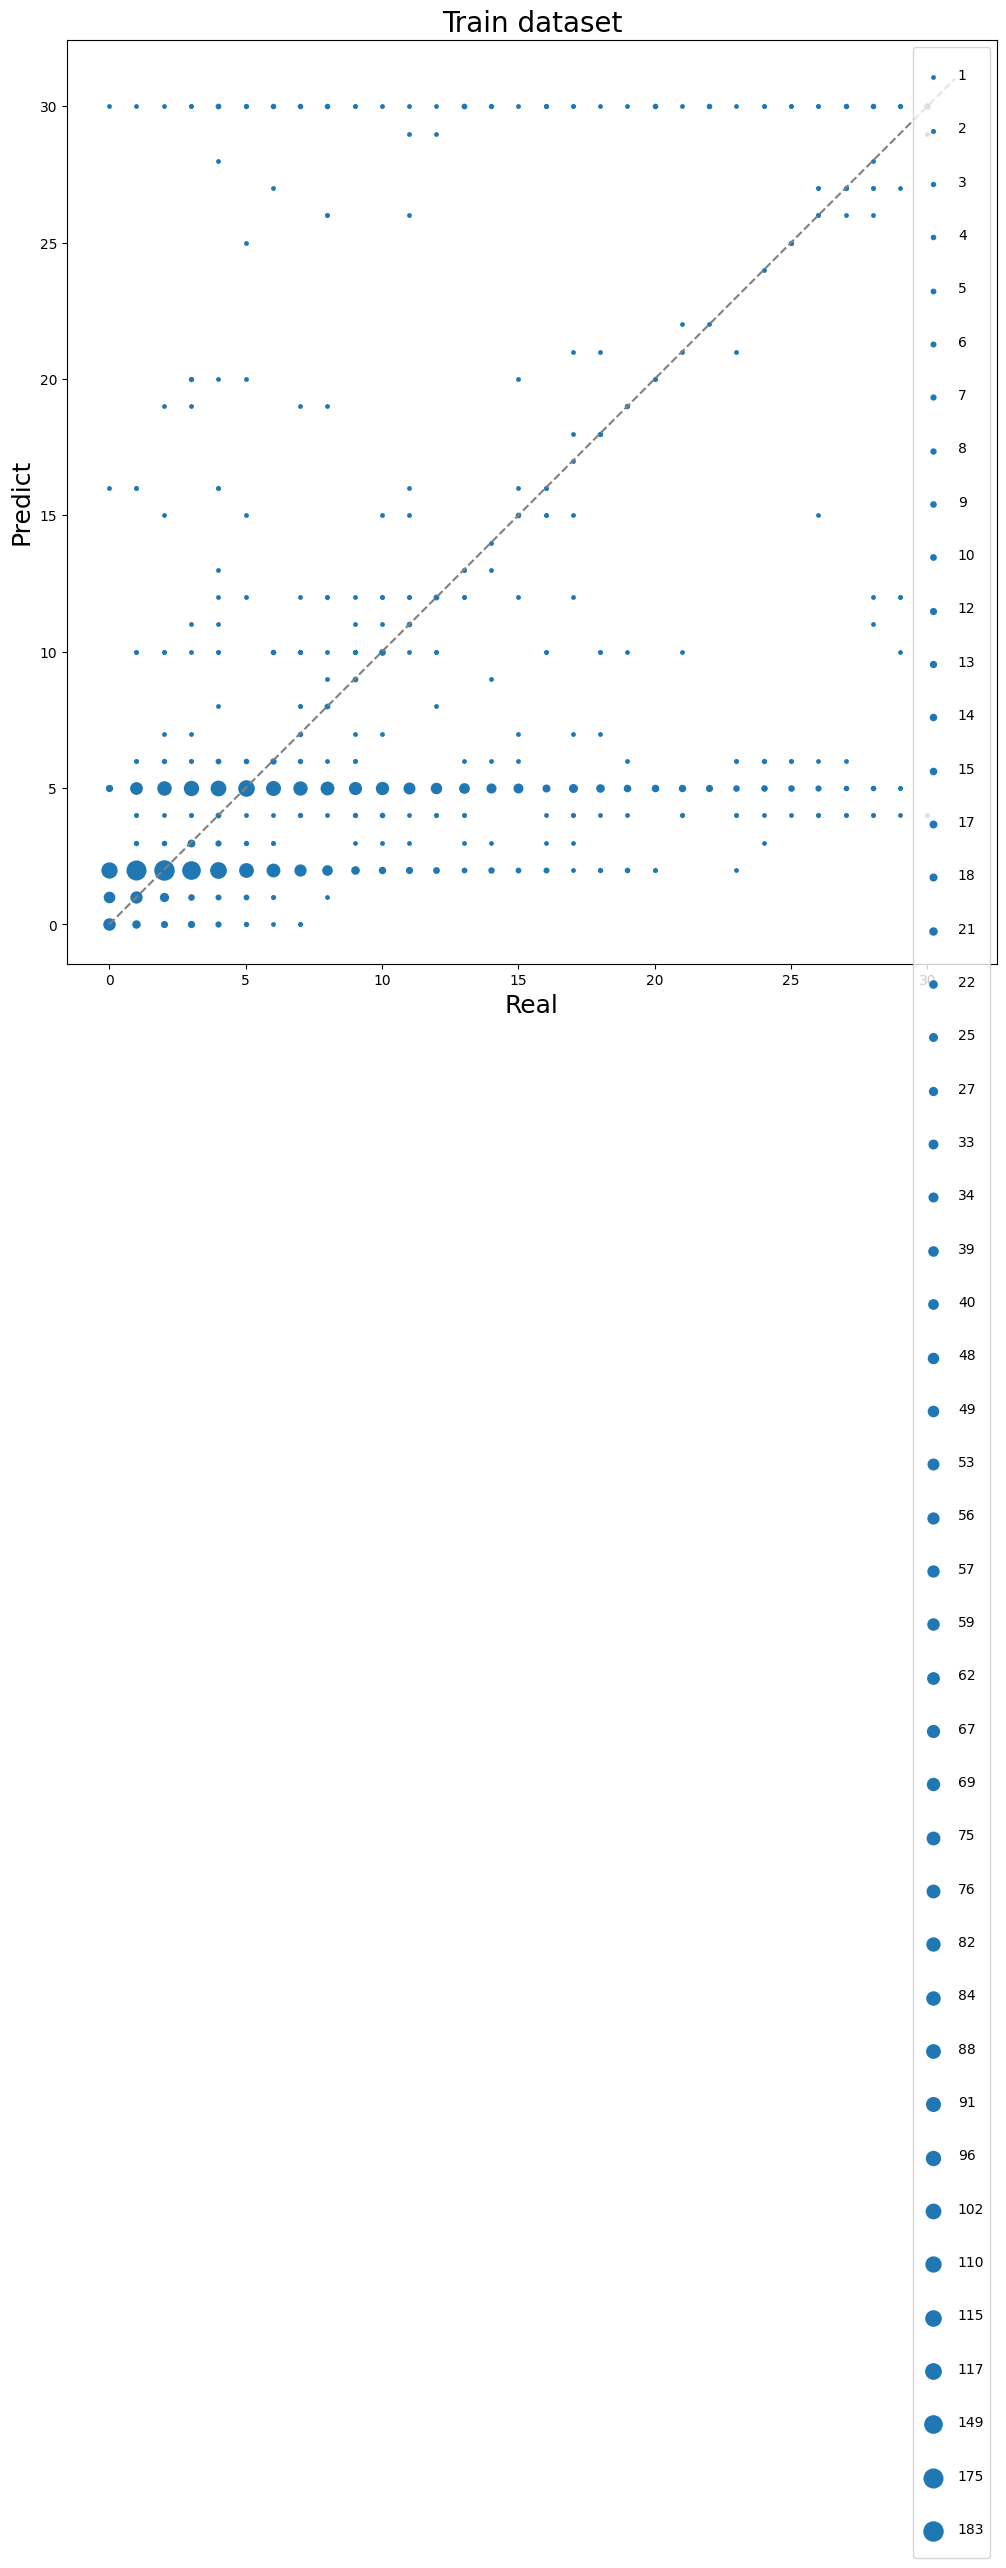

In [24]:
advanced_point_drawer(y_train_nums, y_train_cl_pred_nums)

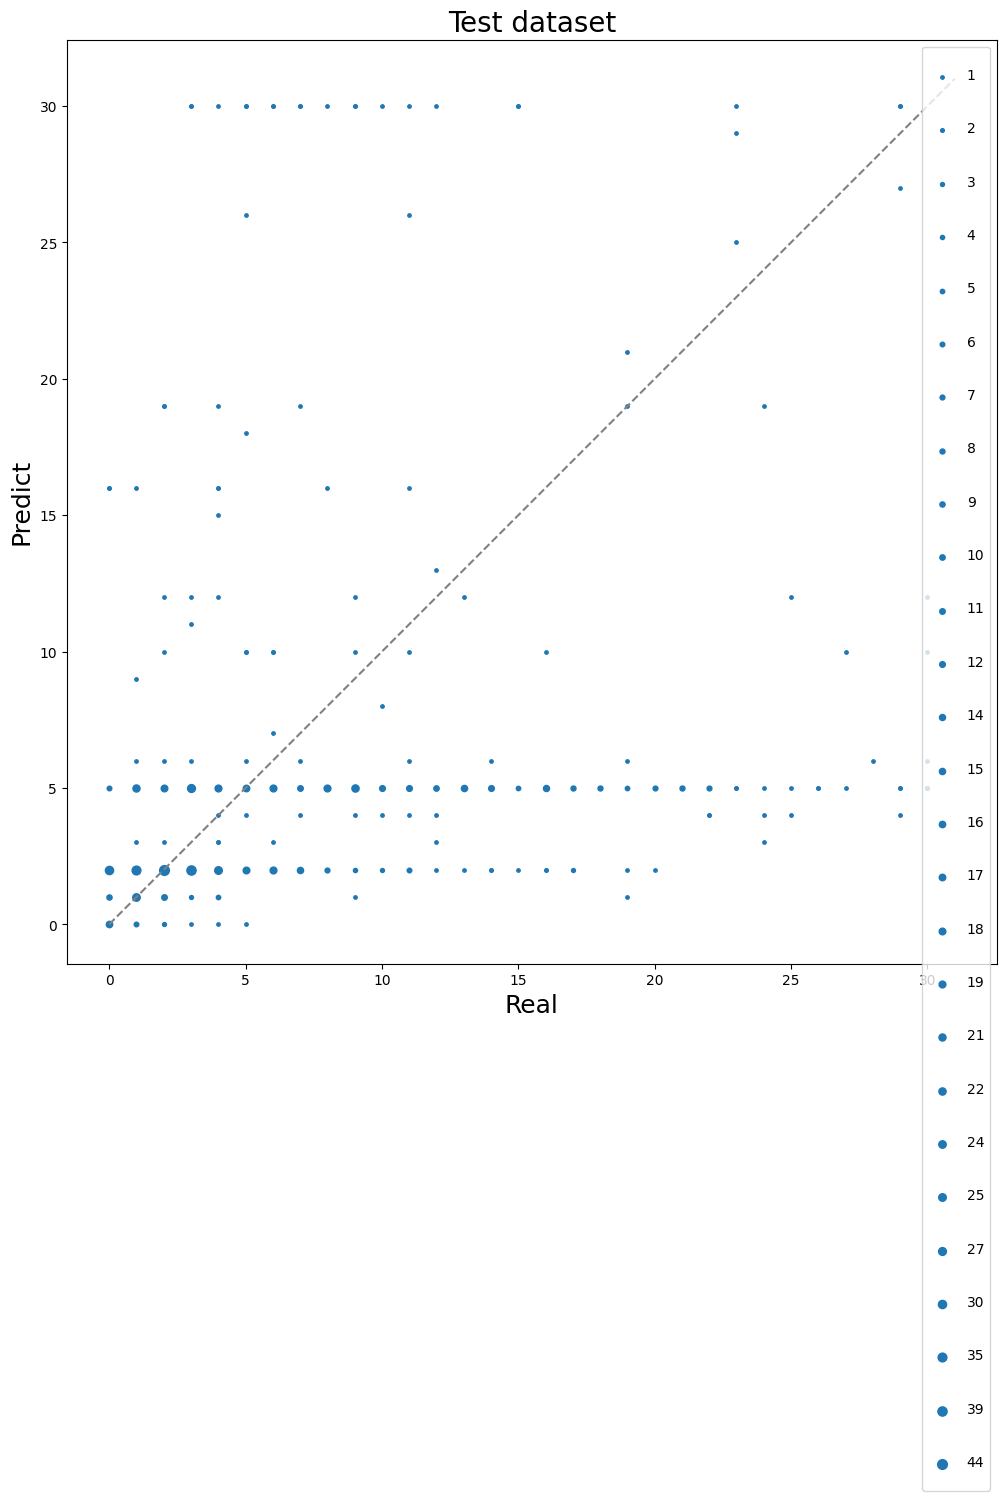

In [25]:
advanced_point_drawer(y_test_nums, y_test_cl_pred_nums, "Test dataset")